# Practical 4: Regression Mining

### In this practical
1. [Resuming from practical 3](#resume)
2. [Building your first logistic regression model](#build)
3. [Understanding your logistic regression model](#viz)
4. [Finding optimal hyperparameters with GridSearchCV](#gridsearch)
5. [Feature selection](#fselect)

---

### Important Changelog:
* (25/07/2017) Made tutorial notes public.
* (22/08/2017) Added details on understanding logistic regression model.

This practical note introduces regression mining in Python. Regressions offer a different approach to predictive mining compared to decision trees. As parametric models, they assume a specific association structure between inputs and target. This relationship can generally be represented by linear mathematical formula, which is used to classify/predict the target value. By contrast, decision trees do not assume any association structure; they simply seek to isolate concentrations of cases with like-valued targets.

In this practical, we will focus on logistic regression. Logistic regression is a class of regression model for classification task. It is similar in structure with linear regression, yet to make a classification prediction, transform the prediction value using logistic function. This practical will gloss over key mathematical concepts of weights, logistic function and cost function of logistic regressions.

You will continue to use the PVA97NK dataset that you had prepared in practical 2.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Resuming from practical 3 <a name="resume"></a>

We will reuse code for data preprocessing from practical 2 and train test split from practical 3.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from dm_tools import data_prep

# preprocessing step
df = data_prep()

# set the random seed - consistent
rs = 42

# train test split
y = df['TargetB']
X = df.drop(['TargetB'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.33, stratify=y, random_state=rs)

## 2. Building your logistic regression <a name="build"></a>

### 2.1. Standardisation

Most machine learning/data mining algorithms, including regression models, are sensitive to input variables on different scales. Input variables on different scales makes comparison between data points difficult. In addition, it also affect **gradient descent** (an algorithm used for training regressions, neural networks, SVMs, etc) by making weights on larger scale inputs updates much faster than smaller scale inputs, resulting in suboptimal model performance.

> To read more about feature scaling, read this excellent blog post from Sebastian Raschka [link](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

To avoid this problem, it is necessary to perform standardisation on the input variables. Standardisation rescale input variables to have mean of 0 and standard deviation of 1, ensuring all of them are on the same scale. In `sklearn`, standardisation can easily be done using `StandardScaler`.

In [2]:
from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 0.0, max 13.0, mean 3.22 and std dev 2.13
Variable #1: min 1.0, max 91.0, mean 10.52 and std dev 9.01
Variable #2: min 0.0, max 9.0, mean 1.86 and std dev 1.59
Variable #3: min 0.0, max 41.0, mean 5.56 and std dev 4.69
Variable #4: min 0.0, max 300.0, mean 15.94 and std dev 11.56
After scaling
-------------
Variable #0: min -1.5114430113546682, max 4.598428471722088, mean -0.00 and std dev 1.00
Variable #1: min -1.056498518078799, max 8.931776287146773, mean -0.00 and std dev 1.00
Variable #2: min -1.1670421736322314, max 4.478785359692482, mean 0.00 and std dev 1.00
Variable #3: min -1.1857485841003292, max 7.554408368615039, mean 0.00 and std dev 1.00
Variable #4: min -1.378325386762708, max 24.5670439171196, mean 0.00 and std dev 1.00


### 2.2. Training logistic regression
Once the input variables are scaled, we are ready to build the model. As discussed before, logistic regression will be build for this classification task. In sklearn, logistic regression is implemented in `sklearn.linear_model.LogisticRegression`.

In [3]:
from sklearn.linear_model import LogisticRegression

Similar with decision tree, initiate a model object (with random state to ensure consistent result) and fit it to the training dataset. 

In [4]:
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

After the model is trained, evaluate the performance of the model on both training and test dataset.

In [5]:
# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.591000154107
Test accuracy: 0.57335001564
             precision    recall  f1-score   support

          0       0.57      0.58      0.58      1599
          1       0.57      0.56      0.57      1598

avg / total       0.57      0.57      0.57      3197



The model produces quite high accuracy score. The training accuracy is still slightly higher than the test accuracy, which indicates slight overfitting. We will tune this logistic regression model later using GridSearchCV.

## 3. Understanding your logistic regression model

Take a deeper look on the model we just built. Firstly, let's gloss over how logistic regression models makes predictions. 

Assume we would like to predict whether a person with data (input variables) $x$ will be a lapsing donor. The target is $y$, which is a binary variable where 0 = non-lapsing donor and 1 = lapsing donor. Logistic regression will predict the target variable $y$ using function $g(\theta, x)$ as following:

$$h(\theta, x) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + ... + \theta_{N}x_{N}$$

$$g(\theta, x) = \frac{1}{1 + e^{h(\theta, x)}}$$

$$y = target$$
$$x = input$$
$$\theta = weights$$

$h(\theta, x)$ is also commonly known as linear regression. The difference between logistic and linear regression is the function $g(\theta, x)$, also called **logistic/sigmoid** function. It transforms $h(\theta,x)$ into range of 0.0 to 1.0, which roughly translates to probability of $y = 1$ (positive, lapsing donor) given $x$. Sigmoid outputs smaller than 0.5 will be classified as 0 and the rest as 1. The output curve of $g(\theta, x)$ looks like this:

![logistic curve](http://dataminingtuts.s3.amazonaws.com/Logistic-curve.svg.png)

During training process, the model tries to learn the optimal values of $\theta$ that results in the most accurate prediction. The algorithm used to find the optimal set of $\theta$ is called **optimisation algorithm**. Some examples of optimisation algorithm including gradient descent (most common and simple), LBFGS, adam, sag and newton-cg. These algorithms aim to minimise the **cost function**, which is the measure of how good predictions made by a model to the supplied $y_{train}$. Given weights of $\theta$, training set $X$ and $y$ with $m$ data points, the cost function $J(\theta)$ of a logistic regression is as follows:

$$J(\theta) = -\frac{1}{m}[\sum_{i=1}^{m} y^{(i)} \log h_{\theta}(x^{(i)}) + (1-y^{(i)}) \log (1-h_{\theta}(x^{(i)}))]$$

Once the model is trained, all of its weights are stored in `.coef_` array of the model.

In [6]:
print(model.coef_)

[[  1.36687717e-01  -2.12380978e-02   6.54628514e-02   3.30126442e-02
   -4.38686589e-02  -2.83771408e-02   6.40736331e-02  -7.20844964e-02
   -1.98930963e-01   2.20104276e-01  -1.09769999e-01   5.39600615e-02
    1.05011793e-01  -1.86421332e-02   6.80105511e-02  -2.86539114e-01
    7.52984487e-02   5.18435829e-02   1.42987172e-02   1.06710992e-01
    1.97601941e-02  -1.00715345e-02  -2.96050009e-03   5.86293914e-02
   -2.24354017e-02   6.16563032e-03   2.45106987e-02  -1.85126946e-02
    2.61665936e-02   2.43035700e-02  -5.52053698e-02  -1.08860824e-02
    1.55106785e-02   1.08469407e-02   2.19113990e-02  -1.81139207e-02
    3.74532308e-03   1.35475240e-02   2.01306439e-02   1.32917139e-02
    6.18625764e-03   7.04399862e-03  -2.21158845e-02   2.73123748e-02
    1.22119421e-02   1.90934216e-02  -2.08735809e-03   4.93020877e-03
   -2.25315064e-02   2.69511329e-02   3.07500306e-02   1.14330043e-02
   -6.63507264e-02   3.20716599e-02  -3.02488291e-02  -3.57157700e-05
    4.22890093e-03  

Each of these values corresponds to a variable/feature in our dataset. We could print out feature name associated with each coefficient with this code below.

In [7]:
feature_names = X.columns
coef = model.coef_[0]

# limit to 20 features, you can comment the following line to print out everything
coef = coef[:20]

for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

GiftCnt36 : 0.136687716723
GiftCntAll : -0.0212380977828
GiftCntCard36 : 0.0654628513642
GiftCntCardAll : 0.0330126441638
GiftAvgLast : -0.0438686588502
GiftAvg36 : -0.0283771408268
GiftAvgAll : 0.0640736331284
GiftAvgCard36 : -0.0720844964335
GiftTimeLast : -0.198930963233
GiftTimeFirst : 0.220104275719
PromCnt12 : -0.109769999258
PromCnt36 : 0.0539600615017
PromCntAll : 0.105011792873
PromCntCard12 : -0.0186421332159
PromCntCard36 : 0.0680105511211
PromCntCardAll : -0.28653911365
StatusCatStarAll : 0.0752984486623
DemAge : 0.0518435829344
DemHomeOwner : 0.0142987172344
DemMedHomeValue : 0.1067109925


Recall again that linear/logistic regressions assume linear correlation between features and prediction values. This relationship is reflected in the weight values.
* Positive coefficient means positive change in the input feature has positive correlation to the prediction value. **DemAge** has positive coefficients, which means older donors (larger age value) are predicted to be more likely to donate back.

* Negative coefficient does the reverse. For example, **GiftTimeLast** has negative coefficient, thus if a donor has not donated for a while, the model predicts it is less likely for them to be a lapsing donor.

In addition to understanding positive/negative correlations between features and prediction values, it is important to learn how much a feature impact the overall prediction value (i.e. feature importance). One way to answer this question is by looking at the absolute value of coefficients. Changes in an important variable (either positive or negative) should correlate to large impact to prediction value, thus the coefficient assign to this variable will have large absolute value. 

This method only applies when the features are standard scaled. Without scaling, each feature can be on different range of values, making larger ranged feature more important by default. For example, in a dataset with **age** and **income**, a **+10** increase in age is significant, but it is meaningless in income. In this scenario, without scaling the coefficients do not help in finding important variables.

The following code will sort the coefficients by their largest absolute value and print the corresponding feature names.

In [8]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

PromCntCardAll : -0.28653911365
GiftTimeFirst : 0.220104275719
GiftTimeLast : -0.198930963233
GiftCnt36 : 0.136687716723
PromCnt12 : -0.109769999258
DemMedHomeValue : 0.1067109925
PromCntAll : 0.105011792873
StatusCatStarAll : 0.0752984486623
GiftAvgCard36 : -0.0720844964335
DemCluster_44 : -0.0718483596406
PromCntCard36 : 0.0680105511211
DemCluster_30 : -0.066350726365
GiftCntCard36 : 0.0654628513642
GiftAvgAll : 0.0640736331284
DemCluster_53 : 0.0630582315942
StatusCat96NK_E : 0.0586293913639
DemCluster_10 : -0.055205369831
PromCnt36 : 0.0539600615017
DemAge : 0.0518435829344
DemCluster_42 : 0.0494568148678


Based on this output, the most important variables in this model is PromCntCardAll, GiftTimeFirst, and GiftTimeLast. These important variables will be different from one model to another.

## 4. Finding optimal hyperparameters with GridSearchCV

Similar to the previous practical, this section will guide you to tune the default model to perform better. In this example, we will only tune one hyperparameter from our logistic regression model, the regularisation strength used in the model. Regularisation is a technique used to prevent overfitting in regression models. We will not go in depth to explain how regularisation works, you can find more information here:
* [Basic of regularisation](https://www.quora.com/What-is-regularization-in-machine-learning)
* [L1 vs L2 regularisation](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)

In `sklearn` logistic regression, regularisation is implemented in the hyperparameter **C**, which denotes the inverse of regularisation strength. Smaller C means stronger regularisation. Typical values for C range from $10^{-6}$ to $10^{4}$, increasing in logarithmic order, which are the values we will use in this example.

**Tips:** `GridSearchCV` can be slow for searching over a large set of possible values. To speed up the searching process, `GridSearchCV` has parallel running capability, where you can specify how many parallel processes running in the same time with `n_jobs` (-1 means GridSearchCV will use as many cores as possible).

In [9]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.589767298505
Test accuracy: 0.568345323741
             precision    recall  f1-score   support

          0       0.57      0.59      0.58      1599
          1       0.57      0.55      0.56      1598

avg / total       0.57      0.57      0.57      3197

{'C': 0.001}


GridSearchCV returns `C` = 0.001 as the optimal parameter. The model performs slightly worse on both training and test accuracy, which can occasionally occur in grid search process. We will explore more techniques on improving model performance later.

## 5. Input transfomation and dimensionality reduction

Other than fine tuning models by performing grid search over their hyperparameters, there are many methods to improve prediction quality from a model. One way is to improve the input features itself, such as with input transformation.

Another method to improve prediction quality from a model is to perform dimensionality reduction on the input set. Dimensionality reduction is divided into two processes:
* Feature selection: Process of selecting a subset of relevant features/variables to be used in constructing models.
* Feature extraction: Process of transforming high-dimensional feature space into lower dimension. Typically performed by finding principle components of the feature space.

In the following sections, we will explore some input transformation and dimensionality reduction techniques.

### 5.1. Logarithmic transformation

Regression models are sensitive to extreme or outlying values in the input space. Inputs with highly skewed or kurtotic distributions are often selected over inputs with better overall predictions. To avoid this problem, analysts often regularise the input distributions using a simple transformation. This approach could improves model performance, at cost of increased difficulty in interpretation.

Examine the variables with **GiftAvg** and **GiftCnt** in their names. Plot their distributions using `sns.distplot`.

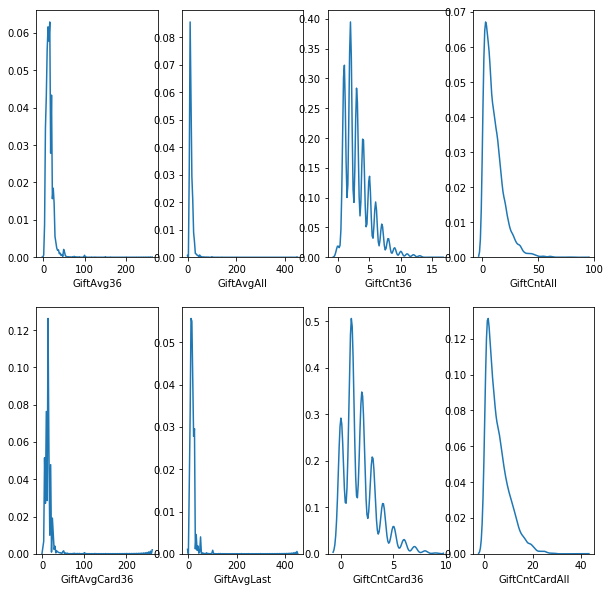

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(2,4, figsize=(10,10), sharex=False)

    # gift avg plots
    sns.distplot(df['GiftAvg36'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['GiftAvgAll'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['GiftAvgCard36'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['GiftAvgLast'].dropna(), hist=False, ax=axes[1,1])

    # gift cnt plots
    sns.distplot(df['GiftCnt36'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['GiftCntAll'].dropna(), hist=False, ax=axes[0,3])
    sns.distplot(df['GiftCntCard36'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['GiftCntCardAll'].dropna(), hist=False, ax=axes[1,3])

    plt.show()
    
plot_skewed_columns(df)

The **GiftAvg** and **GiftCnt** columns show some degree of skew in their distribution. To regularise the skewed distributions, use the log transformation. Log transformation measure the order of magnitude of the underlying measure instead of the measure itself.

Use `pandas.apply()` to apply `np.log()` transformation over these columns.

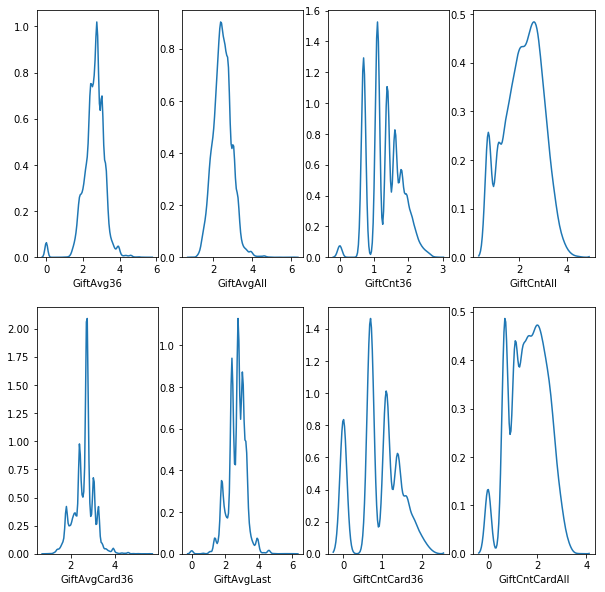

In [11]:
import numpy as np

# list columns to be transformed
columns_to_transform = ['GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36', 'GiftAvgLast',
                        'GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll']

# copy the dataframe
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

After transformation, the columns are much more normally distributed. The next step is to test whether this transformation benefits performance of the model.

Start by rescaling and resampling the training and test data.

In [12]:
# create X, y and train test data partitions
y_log = df_log['TargetB']
X_log = df_log.drop(['TargetB'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.33, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

After the training and test data is ready, run a grid search to find the optimal **C** value again.

In [13]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.580674988442
Test accuracy: 0.575852361589
             precision    recall  f1-score   support

          0       0.57      0.60      0.58      1599
          1       0.58      0.56      0.57      1598

avg / total       0.58      0.58      0.58      3197

{'C': 0.0001}


Log transformation managed to increased the model performance on the test performance slightly.

### 5.2. Recursive feature elimination

The next method is a dimensionality reduction technique called recursive feature elimination (RFE). RFE works by first training the model on all features. Each feature then will be assigned an weight, and features with smallest weight (less important) is eliminated, making a smaller feature set. This process is repeated a number of times until reaching the optimal performance.

In this practical, we will use RFE with cross validation. Cross validation allows RFE to generalise better over the training dataset. RFE with CV is implemented in sklearn under `sklearn.feature_selection.RFECV`. Initiate the RFE with a logistic regression estimator and 10-fold validation and fit it to start eliminating features.

In [14]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 85
Number of features after elimination 9


Once the RFE is fitted, we can transform the original feature set using `.transform`.

In [15]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

RFECV reduced the feature set from 85 variables to only 12 variables. Run another `GridSearchCV` and see whether the feature selection improves the model performance.

In [16]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train))
print("Test accuracy:", cv.score(X_test_sel, y_test))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.584065341347
Test accuracy: 0.585548952143
             precision    recall  f1-score   support

          0       0.58      0.62      0.60      1599
          1       0.59      0.55      0.57      1598

avg / total       0.59      0.59      0.59      3197

{'C': 0.01}


In [17]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs+1), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

X_train_sel_log = rfe.transform(X_train_log)
X_test_sel_log = rfe.transform(X_test_log)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel_log, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_log, y_test_log))

y_pred_log = cv.predict(X_test_sel_log)
print(classification_report(y_test_log, y_pred_log))

# print parameters of the best model
print(cv.best_params_)

Original feature set 85
Number of features after elimination 14
Train accuracy: 0.584373555247
Test accuracy: 0.577416327807
             precision    recall  f1-score   support

          0       0.57      0.60      0.58      1599
          1       0.58      0.56      0.57      1598

avg / total       0.58      0.58      0.58      3197

{'C': 0.1}


The RFE managed to improve the accuracy of our model on test data significantly. In addition to more accurate predictions, with much smaller feature set, the training process is speed up significantly.

### 5.3. Principle Component Analysis

Principal Components Analysis (PCA) is a technique that finds underlying variables (known as principal components) that best differentiate your data points. The idea of PCA is to reduce the number of features while still retaining the variance/pattern in the feature set.

[Intuitive explanation of PCA](https://www.quora.com/What-is-an-intuitive-explanation-for-PCA)

`PCA` is implemented in sklearn under `sklearn.decomposition.PCA`.

In [18]:
from sklearn.decomposition import PCA

With PCA, we need to specify the number of components that we want to retain. How do we know how many components to keep? A commonly used heuristic (rule of thumb) is to ensure 95% of explained variance ratio is retained.

Fit the PCA using X_train. After that, iterate through the `explained_variance_ratio` from the PCA model, and start summing them until it reached at least 95%.

In [19]:
pca = PCA()
pca.fit(X_train)

sum_var = 0
for idx, val in enumerate(pca.explained_variance_ratio_):
    sum_var += val
    if (sum_var >= 0.95):
        print("N components with > 95% variance =", idx+1)
        break

N components with > 95% variance = 66


Now, we know we need to retain 66 components to retain at least 95%. Refit the PCA with 66 components and re-tune the logistic regression model to see if the PCA improves the performance.

In [20]:
# refit the PCA model
pca = PCA(n_components=66)

# transform X_train and X_test according to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_pca, y_train)

print("Train accuracy:", cv.score(X_train_pca, y_train))
print("Test accuracy:", cv.score(X_test_pca, y_test))

# test the best model
y_pred = cv.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.590846047157
Test accuracy: 0.570534876447
             precision    recall  f1-score   support

          0       0.57      0.60      0.58      1599
          1       0.57      0.54      0.56      1598

avg / total       0.57      0.57      0.57      3197

{'C': 0.001}


The result shows an improved performance over the original feature set. We also managed to reduce the feature set size to only 66, which again should shorten the training process.

A disadvantage of PCA is it is a statistical procedure that transforms the original features into a completely different set. The dataset is no longer consisted of variables like `DemAge` or `DemGender`, there are only statistical principle components. Therefore, all of the original fields/columns are gone and all interpretation techniques we explained in section 3 cannot be used to get accurate insights.

### 5.4. Feature selection using model

The last method to be tried on this dataset is "select from model". In this technique, we utilise machine learning models with ability to find feature importance and select the feature set using the computed importance from the trained model. Typically, decision tree or support vector machine models are used in this method. Recall from the previous practical that decision trees can compute feature importance internally through the tree structure. Therefore, we will use decision tree as "selecting model" here.

Firstly, tune a decision tree using the original training data.

In [21]:
from sklearn.tree import DecisionTreeClassifier

# similar parameters with the last practical
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(3, 10),
          'min_samples_leaf': range(20, 200, 20)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(3, 10), 'min_samples_leaf': range(20, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Once the decision tree is trained, analyse the feature importance from this trained model using `analyse_feature_importance()` function we wrote in the previous practical.

In [22]:
from dm_tools import analyse_feature_importance

analyse_feature_importance(cv.best_estimator_, X.columns)

GiftAvgLast : 0.312603065255
DemMedHomeValue : 0.157362668946
GiftTimeLast : 0.102247296701
GiftAvgCard36 : 0.0894450622497
GiftCntCardAll : 0.0564975901627
PromCnt12 : 0.0509281789485
DemPctVeterans : 0.04408455517
PromCntAll : 0.0301916892275
GiftCntAll : 0.026795816426
GiftCnt36 : 0.0264996721409
GiftAvg36 : 0.0250858556392
DemMedIncome : 0.0195942277141
GiftAvgAll : 0.018633476267
PromCntCard36 : 0.0167406544809
PromCntCardAll : 0.0122122046814
PromCntCard12 : 0.0110779859909
GiftTimeFirst : 0.0
DemCluster_10 : 0.0
DemCluster_11 : 0.0
DemCluster_12 : 0.0


The output shows there are only 15 features with importance value more than 0. This means according to our decision tree, there are only 15 important features in our dataset. We could now use this decision tree to perform feature selection. Import `SelectFromModel` module from `sklearn.feature_selection`.

In [23]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(6489, 15)


The shape of X_train shows there are only 15 feature left, exactly what the decision tree suggests. Let's train and tune another logistic regression model from this new data set.

In [24]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

# test the best model
y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.582216057944
Test accuracy: 0.584297779168
             precision    recall  f1-score   support

          0       0.58      0.61      0.59      1599
          1       0.59      0.56      0.57      1598

avg / total       0.58      0.58      0.58      3197

{'C': 1000}


The test accuracy result shows improvement over the original feature set as well. This demonstrates the effectiveness of dimensionality reduction.

## End notes and next week

This week, we learned how to build, tune and explore the structure of logistic regression models. We also explored dimensionality reduction techniques to reduce the size of the feature set and improve performance of our logistic regression model.

Next week, we will learn how to perform predictive modelling with neural networks and comparing the end-to-end performance of all the models we have built so far.